In [12]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed


In [13]:
# Constants
GRID_HEIGHT = 4
GRID_WIDTH = 12
START_STATE = (3, 0)
GOAL_STATE = (3, 11)
CLIFF_STATES = [(3, i) for i in range(1, 11)]
ACTIONS = ['U', 'D', 'L', 'R']
EPSILON = 0.1
ALPHA = 0.5
GAMMA = 1.0
NUM_EPISODES = 500
NUM_RUNS = 500  # Number of runs to average over


In [14]:
class CliffWalkingEnv:
    """
    Cliff Walking Environment.

    Represents the gridworld for the cliff walking task.
    The agent starts at the START_STATE and aims to reach the GOAL_STATE.
    Stepping into the cliff results in a large negative reward and returns the agent to the start state.
    """
    def __init__(self):
        self.height = GRID_HEIGHT
        self.width = GRID_WIDTH
        self.start_state = START_STATE
        self.goal_state = GOAL_STATE
        self.cliff_states = CLIFF_STATES
        self.reset()
        
    def reset(self):
        """
        Reset the environment to the start state.

        Returns:
            state (tuple): The starting state.
        """
        self.state = self.start_state
        return self.state
        
    def step(self, action):
        """
        Take an action in the environment.

        Parameters:
            action (str): One of 'U', 'D', 'L', 'R'.

        Returns:
            next_state (tuple): The next state after taking the action.
            reward (float): The reward received after taking the action.
            done (bool): Whether the episode has ended.
        """
        x, y = self.state
        if action == 'U':
            x = max(x - 1, 0)
        elif action == 'D':
            x = min(x + 1, self.height - 1)
        elif action == 'L':
            y = max(y - 1, 0)
        elif action == 'R':
            y = min(y + 1, self.width - 1)
        
        next_state = (x, y)
        
        if next_state in self.cliff_states:
            reward = -100
            next_state = self.start_state
            done = False
        elif next_state == self.goal_state:
            reward = -1
            done = True
        else:
            reward = -1
            done = False
        
        self.state = next_state
        return next_state, reward, done


In [15]:
def epsilon_greedy(Q, state, epsilon=EPSILON):
    """
    Epsilon-greedy action selection.

    Chooses an action using an epsilon-greedy policy based on the Q-values.

    Parameters:
        Q (dict): State-action value function mapping (state, action) pairs to values.
        state (tuple): Current state.
        epsilon (float): Exploration rate (probability of choosing a random action).

    Returns:
        action (str): Selected action.
    """
    if np.random.rand() < epsilon:
        # Exploration: choose a random action
        return np.random.choice(ACTIONS)
    else:
        # Exploitation: choose the best action based on current Q-values
        values = [Q.get((state, a), 0) for a in ACTIONS]
        max_value = max(values)
        # In case multiple actions have the same max value, select one at random
        max_actions = [a for a, v in zip(ACTIONS, values) if v == max_value]
        return np.random.choice(max_actions)


In [16]:
def sarsa(env, num_episodes=NUM_EPISODES, alpha=ALPHA, gamma=GAMMA, epsilon=EPSILON):
    """
    Sarsa algorithm for estimating the optimal policy.

    Parameters:
        env (CliffWalkingEnv): The environment to interact with.
        num_episodes (int): Number of episodes to run.
        alpha (float): Learning rate.
        gamma (float): Discount factor.
        epsilon (float): Exploration rate.

    Returns:
        sum_rewards (list): List containing the sum of rewards per episode.
    """
    Q = {}  # State-action value function
    sum_rewards = []  # Sum of rewards per episode
    for episode in range(num_episodes):
        state = env.reset()
        action = epsilon_greedy(Q, state, epsilon)
        done = False
        total_reward = 0
        while not done:
            next_state, reward, done = env.step(action)
            total_reward += reward
            next_action = epsilon_greedy(Q, next_state, epsilon)
            # Update Q-value using the Sarsa update rule
            q_predict = Q.get((state, action), 0)
            q_target = reward + gamma * Q.get((next_state, next_action), 0)
            Q[(state, action)] = q_predict + alpha * (q_target - q_predict)
            state = next_state
            action = next_action
        sum_rewards.append(total_reward)
    return sum_rewards


In [17]:
def q_learning(env, num_episodes=NUM_EPISODES, alpha=ALPHA, gamma=GAMMA, epsilon=EPSILON):
    """
    Q-learning algorithm for estimating the optimal policy.

    Parameters:
        env (CliffWalkingEnv): The environment to interact with.
        num_episodes (int): Number of episodes to run.
        alpha (float): Learning rate.
        gamma (float): Discount factor.
        epsilon (float): Exploration rate.

    Returns:
        sum_rewards (list): List containing the sum of rewards per episode.
    """
    Q = {}  # State-action value function
    sum_rewards = []  # Sum of rewards per episode
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = epsilon_greedy(Q, state, epsilon)
            next_state, reward, done = env.step(action)
            total_reward += reward
            # Select the action with the maximum Q-value at the next state
            next_values = [Q.get((next_state, a), 0) for a in ACTIONS]
            max_next_value = max(next_values)
            # Update Q-value using the Q-learning update rule
            q_predict = Q.get((state, action), 0)
            q_target = reward + gamma * max_next_value
            Q[(state, action)] = q_predict + alpha * (q_target - q_predict)
            state = next_state
        sum_rewards.append(total_reward)
    return sum_rewards


In [18]:
def run_sarsa(run):
    """
    Run a single instance of the Sarsa algorithm.

    Parameters:
        run (int): The run index (used for setting the random seed).

    Returns:
        sum_rewards (list): Sum of rewards per episode for this run.
    """
    np.random.seed(run)  # Ensure randomness is independent across runs
    env = CliffWalkingEnv()
    return sarsa(env)


In [19]:
def run_q_learning(run):
    """
    Run a single instance of the Q-learning algorithm.

    Parameters:
        run (int): The run index (used for setting the random seed).

    Returns:
        sum_rewards (list): Sum of rewards per episode for this run.
    """
    np.random.seed(run + NUM_RUNS)  # Offset seed to differ from Sarsa runs
    env = CliffWalkingEnv()
    return q_learning(env)


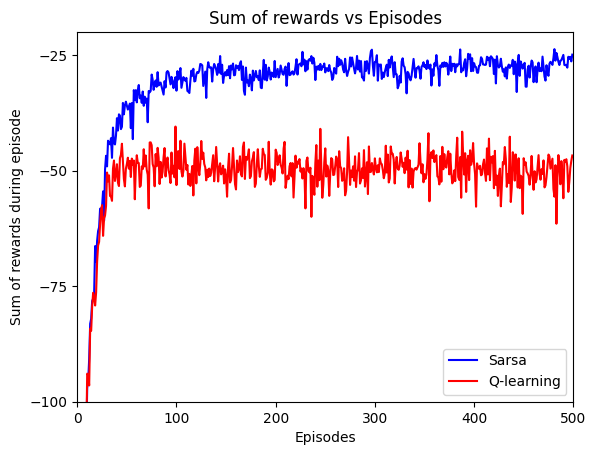

In [20]:
def main():
    """
    Main function to run Sarsa and Q-learning algorithms and plot the results.
    """
    # Run Sarsa in parallel over NUM_RUNS
    sarsa_all_rewards = Parallel(n_jobs=-1)(
        delayed(run_sarsa)(run) for run in range(NUM_RUNS)
    )

    # Run Q-learning in parallel over NUM_RUNS
    q_learning_all_rewards = Parallel(n_jobs=-1)(
        delayed(run_q_learning)(run) for run in range(NUM_RUNS)
    )
    
    # Average the rewards over all runs
    sarsa_avg_rewards = np.mean(sarsa_all_rewards, axis=0)
    q_learning_avg_rewards = np.mean(q_learning_all_rewards, axis=0)
    
    # Plot the results
    plt.plot(sarsa_avg_rewards, label='Sarsa', color='blue')
    plt.plot(q_learning_avg_rewards, label='Q-learning', color='red')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    plt.title('Sum of rewards vs Episodes')
    plt.legend()
    plt.ylim(-100, -20)  # Adjusted upper limit to -20 for padding
    plt.yticks([-100, -75, -50, -25])  # Set y-axis labels
    plt.xlim(0, NUM_EPISODES)
    plt.show()

if __name__ == '__main__':
    main()
